## Testing of BLIP2-Pretrained Model

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Fine Tuning

In [ ]:

# !pip install --upgrade protobuf
# !pip install peft evaluate rouge-score
# !pip install -U bitsandbytes accelerate transformers

In [8]:
import torch

from transformers import (
    Blip2Processor, 
    Blip2ForConditionalGeneration,
    Blip2VisionConfig,
    Blip2QFormerConfig,
    Blip2Config,
    BitsAndBytesConfig,
)

from peft import (
    LoraConfig, 
    get_peft_model, 
    prepare_model_for_kbit_training
)

**Use Model with lower number of parameters and layers (Change the configuration)**

In [4]:

# vision_config = Blip2VisionConfig(
#     hidden_size=768,           
#     num_hidden_layers=12,      
#     num_attention_heads=12,    
#     intermediate_size=3072,    
#     image_size=224,            
#     patch_size=16,            
# )

# qformer_config = Blip2QFormerConfig(
#     hidden_size=512,           
#     num_hidden_layers=8,       
#     num_attention_heads=8,     
#     intermediate_size=2048,    
#     num_query_tokens=16,       
# )

# config = Blip2Config(
#     vision_config=vision_config.to_dict(),
#     qformer_config=qformer_config.to_dict(),
#     use_decoder_only_language_model=True,
# )

In [5]:

# model = Blip2ForConditionalGeneration(config=config)

# trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# total_params = sum(p.numel() for p in model.parameters())

# print(f"Trainable Parameter : {trainable_params/1e9} b")
# print(f"Total Parameter : {total_params / 1e9} b")
# print(f"Trainable Params Size: {trainable_params * 4/(1024 * 1024 * 1024):.3f} GiB")
# print(f"Total Parameters Size: {total_params * 4/ (1024 * 1024 * 1024):.3f} GiB")

**Or Download A pre-trrained Model and Use train the Q-Former Only**

In [ ]:

# model_name = "Salesforce/blip2-flan-t5-xl"
model_name = "Salesforce/blip2-opt-2.7b"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

processor = Blip2Processor.from_pretrained(model_name, cache_dir="../data/cache")

model = Blip2ForConditionalGeneration.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    cache_dir="../data/cache"
)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:

# Prepare model for k-bit training (required for quantized models)
model = prepare_model_for_kbit_training(model)

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)


model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


trainable params: 5,242,880 || all params: 3,750,004,736 || trainable%: 0.1398


In [5]:

for params in model.vision_model.parameters():
    params.requires_grad = False

# for params in model.language_model.parameters():
#     params.requires_grad = False
    
for params in model.qformer.parameters():
    params.requires_grad = True
    
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())

print(f"Trainable Parameter : {trainable_params/1e9} b")
print(f"Total Parameter : {total_params / 1e9} b")
print(f"Trainable Params Size: {trainable_params * 4/(1024 * 1024 * 1024):.3f} GiB")
print(f"Total Parameters Size: {total_params * 4/ (1024 * 1024 * 1024):.3f} GiB")

Trainable Parameter : 0.110380544 b
Total Parameter : 1.998718976 b
Trainable Params Size: 0.411 GiB
Total Parameters Size: 7.446 GiB


**Download & Save Dataset**

In [10]:
from datasets import load_dataset, load_from_disk

In [ ]:
splits = ["train", "validation", "test"]
if os.path.exists("../data/flickr8k/train") and os.path.exists("../data/flickr8k/test") and os.path.exists("../data/flickr8k/validation"):
    print("Dataset Already Exists")
else:    
    flickr8k = load_dataset("jxie/flickr8k", split=splits)
    for idx, split in enumerate(splits):
        directory = f"../data/flickr8k/{split}"
        os.makedirs(directory, exist_ok=True)
        flickr8k[idx].save_to_disk(dataset_path=directory)

In [11]:

train_dataset = load_from_disk("../data/flickr8k/train")

**Some samples**

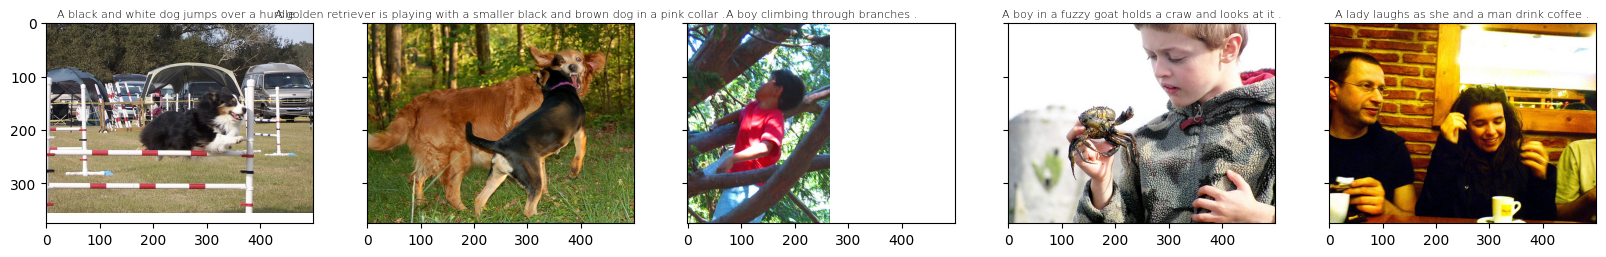

In [9]:
fig, axes = plt.subplots(1,5, figsize=(20, 20), sharex=True, sharey=True)
index = np.random.randint(0, len(train_dataset)-5)
for i in range(len(axes)):
    axes[i].imshow(train_dataset[index+i]['image'])
    caption = train_dataset[index+i]['caption_0']
    axes[i].set_title(caption, fontsize=8, fontweight="light", pad=4)

**Dataset Class**

In [10]:
from torch.utils.data import Dataset, DataLoader

In [11]:

from typing import Any

class ImageCaptioning(Dataset):
    def __init__(self, file_path:str, processor:Blip2Processor):
        super().__init__()
        assert os.path.exists(file_path), "File does not exists"
        self.data = load_from_disk(file_path)
        self.processor = processor
        self.current_epoch = 0
        
    
    def set_epoch(self, epoch):
        self.current_epoch = epoch
        
    
    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, index):
        image = self.data[index]['image']
        cap_idx = self.current_epoch % 5
        # cap_idx = np.random.randint(0, 5)
        cap_idx = f"caption_{cap_idx}"
        caption = self.data[index][cap_idx]
        return image, caption
    
    
    def collate_fn(self, batch):
        images, captions = zip(*batch)
        
        encoding = self.processor(
            images=list(images),
            text=list(captions),
            padding="longest",
            max_length=50,
            truncation=True,
            return_tensors="pt"
        )
        
        return encoding['pixel_values'], encoding['input_ids'], encoding['attention_mask']    

In [ ]:

# train_dataset = ImageCaptioning("../data/flickr8k/train", processor=processor)
# dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False, collate_fn=train_dataset.collate_fn)

In [13]:

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# pixel_values, input_ids, attention_mask = next(iter(dataloader))
# pixel_values = pixel_values.to(device)
# input_ids = input_ids.to(device)
# attention_mask = attention_mask.to(device)

In [15]:

# model.to(device)
# output = model(pixel_values=pixel_values.to(device), 
#                input_ids=input_ids.to(device), 
#                labels=input_ids.to(device),
#                )
# output.loss

tensor(12.4100, device='cuda:0', grad_fn=<NllLossBackward0>)

**Metrics for Evaluation**

In [12]:
import evaluate

bleu_metric = evaluate.load("bleu")
meteor_metric = evaluate.load("meteor")
rouge_metric = evaluate.load("rouge")

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/gpuserver2x/nltk_data...
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/gpuserver2x/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/gpuserver2x/nltk_data...


### Pytorch Lightning Model

In [13]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, Callback

In [14]:
class LightningWrapper(pl.LightningModule):
    def __init__(self, model:Blip2ForConditionalGeneration, processor:Blip2Processor):
        super().__init__()
        self.model = model
        self.processor = processor
        

    def forward(self, pixel_values:torch.Tensor, input_ids:torch.Tensor, attention_mask:torch.Tensor):
        return self.model(input_ids=input_ids, pixel_values=pixel_values, labels=input_ids, attention_mask=attention_mask)
    
    def generate(self, pixel_values:torch.Tensor):
        return self.model.generate(pixel_values=pixel_values, max_length=50)


    def training_step(self, batch, batch_idx):
        pixel_values, input_ids, attention_mask = batch
        output = self(pixel_values, input_ids, attention_mask)
        loss = output.loss

        self.log('train_loss_batch', loss.item(), on_step=True, on_epoch=True, prog_bar=True)
        return loss

    
    def validation_step(self, batch, batch_idx):
        pixel_values, input_ids, attention_mask = batch
        generated_ids = self.generate(pixel_values=pixel_values)
        
        metrics = self.compute_metrics_multi_ref((generated_ids, input_ids))
        self.log('val_bleu', metrics['bleu'], prog_bar=True, on_epoch=True)
        self.log('val_rouge', metrics['rougeL'], prog_bar=True, on_epoch=True)
        self.log('val_meteor', metrics['meteor'], prog_bar=True, on_epoch=True)
        
        return metrics
        
    
    def on_train_epoch_end(self):
        avg_loss = self.trainer.callback_metrics.get('train_loss_batch')
        self.log('train_loss', avg_loss)
        print(f"Training_loss : {avg_loss:.6f}")
    

    def on_validation_epoch_end(self):
        bleu = self.trainer.callback_metrics.get('val_bleu')
        meteor = self.trainer.callback_metrics.get('val_meteor')
        rouge = self.trainer.callback_metrics.get('val_rouge')

        self.log("bleu", bleu)
        self.log("meteor", meteor)
        self.log("rouge", rouge)

        print(f"\nEpoch : {self.current_epoch}/{self.trainer.max_epochs}")
        print(f"BLEU : {bleu:.6f}")
        print(f"METEOR : {meteor:.6f}")
        print(f"ROUGE : {rouge:.6f}")

        
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=5e-5)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=self.trainer.max_epochs,
            eta_min=1e-6
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'epoch'
            }
        }
    
    def compute_metrics_multi_ref(self, eval_pred):
        predictions, labels = eval_pred
        
        decoded_preds = self.processor.batch_decode(predictions, skip_special_tokens=True)
        decoded_preds = [pred.strip() for pred in decoded_preds]
        
        decoded_labels = self.processor.batch_decode(labels, skip_special_tokens=True)
        decoded_labels = [label.strip() for label in decoded_labels]
        
        bleu_result = bleu_metric.compute(
            predictions=decoded_preds,
            references=[[label] for label in decoded_labels]
        )
        
        meteor_result = meteor_metric.compute(
            predictions=decoded_preds,
            references=[[label] for label in decoded_labels]
        )
        
        rouge_result = rouge_metric.compute(
            predictions=decoded_preds,
            references=[[label] for label in decoded_labels]
        )
        
        return {
            "bleu": bleu_result["bleu"],
            "bleu_1": bleu_result["precisions"][0],
            "bleu_2": bleu_result["precisions"][1],
            "bleu_3": bleu_result["precisions"][2],
            "bleu_4": bleu_result["precisions"][3],
            "meteor": meteor_result["meteor"],
            "rouge1": rouge_result["rouge1"],
            "rouge2": rouge_result["rouge2"],
            "rougeL": rouge_result["rougeL"],
        }
    
    
    def get_model(self):
        return self.model

In [15]:

checkpoint_callback = ModelCheckpoint(
    dirpath='../data/model',
    filename=f'blip2_sft_{{epoch}}',
    save_top_k=2,
    save_last=True,
    monitor='bleu',
    mode='max'
)

class PrintCallback(Callback):
    def on_train_start(self, trainer, pl_module):
        print("Training started!")
    def on_train_end(self, trainer, pl_module):
        print("Training is done.")

class EpochTrackerCallback(pl.Callback):
    def on_train_epoch_start(self, trainer, pl_module):
        """Update epoch in train dataset"""
        try:
            dataset = trainer.train_dataloader.dataset
            if hasattr(dataset, 'set_epoch'):
                dataset.set_epoch(trainer.current_epoch)
        except (AttributeError, TypeError) as e:
            print(f"Could not update train dataset epoch: {e}")
    
    def on_validation_epoch_start(self, trainer, pl_module):
        """Update epoch in validation dataset"""
        try:
            val_loaders = trainer.val_dataloaders
            if hasattr(val_loaders, 'dataset'):
                if hasattr(val_loaders.dataset, 'set_epoch'):
                    val_loaders.dataset.set_epoch(trainer.current_epoch)
                    
            elif isinstance(val_loaders, (list, tuple)):
                for loader in val_loaders:
                    if hasattr(loader, 'dataset') and hasattr(loader.dataset, 'set_epoch'):
                        loader.dataset.set_epoch(trainer.current_epoch)
        except (AttributeError, TypeError) as e:
            print(f"Could not update val dataset epoch: {e}")

In [16]:

BLIP2 = LightningWrapper(model=model, processor=processor)

In [17]:

trainer = pl.Trainer(
    max_epochs=20,
    accelerator='auto',
    devices=1,
    callbacks=[PrintCallback(), checkpoint_callback, EpochTrackerCallback()],
    gradient_clip_val=1.0,
    gradient_clip_algorithm="norm",
    accumulate_grad_batches=4,
    logger=True,
    # limit_train_batches=5,
    # limit_val_batches=5
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/mnt/storage2/arafat_shovon/flow_matching_and_llm/flow_env/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [18]:

train_dataset = ImageCaptioning("../data/flickr8k/train", processor=processor)
val_dataset = ImageCaptioning("../data/flickr8k/validation", processor=processor)
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=train_dataset.collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=val_dataset.collate_fn)


In [ ]:

trainer.fit(BLIP2, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                 | Params | Mode 
-------------------------------------------------------
0 | model | PeftModelForCausalLM | 2.0 B  | train
-------------------------------------------------------
110 M     Trainable params
1.9 B     Non-trainable params
2.0 B     Total params
7,994.876 Total estimated model params size (MB)
642       Modules in train mode
1039      Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/mnt/storage2/arafat_shovon/flow_matching_and_llm/flow_env/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.



Epoch : 0/20
BLEU : 0.022579
METEOR : 0.225255
ROUGE : 0.355216
Training started!


/mnt/storage2/arafat_shovon/flow_matching_and_llm/flow_env/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/mnt/storage2/arafat_shovon/flow_matching_and_llm/flow_env/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:527: Found 1039 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore this warning.


Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:


# print("="*60)
# print("MODEL FORWARD PASS TEST")
# print("="*60)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)
# model.eval()

# print(f"Device: {device}")
# print(f"Model device: {next(model.parameters()).device}")
# print(f"Model dtype: {next(model.parameters()).dtype}")

# # Test vision encoder only
# print("\n--- Testing Vision Encoder ---")
# try:
#     with torch.no_grad():
#         vision_outputs = model.vision_model(pixel_values=pixel_values)
#         image_embeds = vision_outputs[0]
#         print(f"✓ Vision encoder output shape: {image_embeds.shape}")
#         print(f"  Range: [{image_embeds.min():.4f}, {image_embeds.max():.4f}]")
#         print(f"  Mean: {image_embeds.mean():.4f}")
#         print(f"  Has NaN: {torch.isnan(image_embeds).any()}")
#         print(f"  Has Inf: {torch.isinf(image_embeds).any()}")
# except Exception as e:
#     print(f"✗ Vision encoder failed: {e}")
#     import traceback
#     traceback.print_exc()

# # Test Q-Former
# print("\n--- Testing Q-Former ---")
# try:
#     with torch.no_grad():
#         query_tokens = model.query_tokens.expand(image_embeds.shape[0], -1, -1)
#         query_outputs = model.qformer(
#             query_embeds=query_tokens,
#             encoder_hidden_states=image_embeds,
#             return_dict=True
#         )
#         print(f"✓ Q-Former output shape: {query_outputs.last_hidden_state.shape}")
#         print(f"  Range: [{query_outputs.last_hidden_state.min():.4f}, {query_outputs.last_hidden_state.max():.4f}]")
#         print(f"  Has NaN: {torch.isnan(query_outputs.last_hidden_state).any()}")
# except Exception as e:
#     print(f"✗ Q-Former failed: {e}")
#     import traceback
#     traceback.print_exc()

# # Test full forward pass
# print("\n--- Testing Full Forward Pass ---")
# try:
#     with torch.no_grad():
#         outputs = model(
#             pixel_values=pixel_values,
#             input_ids=input_ids,
#             attention_mask=attention_mask,
#             labels=input_ids,
#             return_dict=True
#         )
#         print(f"✓ Forward pass successful")
#         print(f"  Loss: {outputs.loss.item():.6f}")
#         print(f"  Loss is NaN: {torch.isnan(outputs.loss).any()}")
#         print(f"  Loss is Inf: {torch.isinf(outputs.loss).any()}")
        
#         if hasattr(outputs, 'logits'):
#             print(f"  Logits shape: {outputs.logits.shape}")
#             print(f"  Logits range: [{outputs.logits.min():.4f}, {outputs.logits.max():.4f}]")
#             print(f"  Logits has NaN: {torch.isnan(outputs.logits).any()}")
# except Exception as e:
#     print(f"✗ Forward pass failed: {e}")
#     import traceback
#     traceback.print_exc()

# print("="*60 + "\n")

a child in a toy car



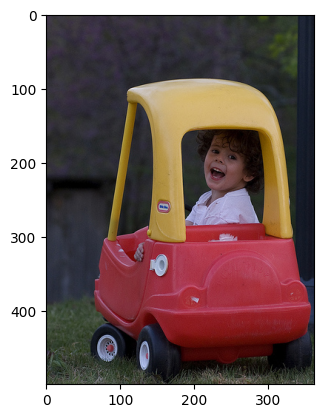

In [15]:
index = 101
image = train_dataset[index]['image']

inputs = processor(images=image, return_tensors="pt").to("cuda", dtype=torch.float16)
generated_ids = model.generate(**inputs, max_length=50)
print(processor.decode(generated_ids[0], skip_special_tokens=True))

plt.imshow(image)